<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_slingshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
system.time({
install.packages(c("BiocManager", "scales", "viridis", "ggsci"))
BiocManager::install(c("slingshot", "BUSpaRse", "SingleR", 
"DropletUtils", "scater", "scran", "tradeSeq"), Ncpus = 2)
})

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'slingshot', 'BUSpaRse', 'SingleR',
  'DropletUtils', 'scater', 'scran', 'tradeSeq'

also installing the dependencies ‘bit’, ‘formatR’, ‘bibtex’, ‘iterators’, ‘annotate’, ‘bit64’, ‘blob’, ‘zlibbioc’, ‘bitops’, ‘Rhtslib’, ‘lambda.r’, ‘futile.options’, ‘interactiveDisplayBase’, ‘pkgmaker’, ‘registry’, ‘rngtools’, ‘gridBase’, ‘foreach’, ‘doParallel’, ‘RcppEigen’, ‘softImpute’, ‘genefilter’, ‘ade4’, ‘rncl’, ‘RNeXML’, ‘Biobase’, ‘IRanges’, ‘RSQLite’, ‘XML’, ‘BiocFileCache’, ‘rappdirs’, ‘XVector’, ‘rtracklayer’, ‘Rsamtools’, ‘ProtGenerics’, ‘RCurl’, ‘GenomeInfoDbData’, ‘GenomicAlignments’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘futile.logger’, ‘snow’, ‘AnnotationHub’, ‘locfit’, ‘R.oo’, ‘R.methodsS3’, ‘sitmo’, ‘beeswarm’, ‘vipor’, ‘irlba’, ‘rsvd’, ‘NMF’, ‘howmany’, ‘locfdr

    user   system  elapsed 
3927.901  271.269 2157.764 

In [77]:
devtools::install_github('cole-trapnell-lab/leidenbase')


✔  checking for file ‘/tmp/Rtmp3ZgCkF/remotes82750bfffa/cole-trapnell-lab-leidenbase-c22a7d0/DESCRIPTION’ (345ms)
─  preparing ‘leidenbase’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories (578ms)
─  building ‘leidenbase_0.1.0.tar.gz’
   


Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



In [0]:
system("pip3 install kb-python")

In [156]:
library(slingshot)
library(BUSpaRse)
library(DropletUtils)
library(SingleR)
library(tidyverse)
library(Seurat)
library(ggsci)
library(viridis)
library(Matrix)
library(scater)
library(scran)
library(tradeSeq)
library(BiocParallel)
library(clusterExperiment)
theme_set(theme_bw())

tradeSeq has been updated to accommodate singleCellExperiment objects as output, making it much more memory efficient. Please check the news file and the updated vignette for details.



In [0]:
# Download data
if (!dir.exists("./data")) dir.create("./data")
if (!file.exists("./data/neuron_1k_v3_fastqs.tar")) {
  download.file("http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v3/neuron_1k_v3_fastqs.tar", 
      "./data/neuron_1k_v3_fastqs.tar", method = "wget", quiet = TRUE)
}

In [0]:
untar("./data/neuron_1k_v3_fastqs.tar", exdir = "./data")

In [10]:
system("kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta",intern=TRUE)

character(0)

In [0]:
system("chmod -R 777 data/")

In [14]:
fn <- list.files("data/neuron_1k_v3_fastqs", full.names = TRUE)
fn <- fn[str_detect(fn, "R\\d_")]
fn

[1] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L001_R1_001.fastq.gz"
[2] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L001_R2_001.fastq.gz"
[3] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L002_R1_001.fastq.gz"
[4] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L002_R2_001.fastq.gz"

In [16]:
system(paste("kb count -i reference/mm_tr_index99.idx -g reference/tr2g_mm99.tsv -x 10xv3 -o output",
paste(fn, collapse = " ")), intern = TRUE)

character(0)

In [0]:
res_mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes", tcc = FALSE)

In [18]:
dim(res_mat)

[1]  36711 399524

In [19]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      1.00      1.00     40.47      5.00 154216.00 

In [0]:
# Compute barcode rank
bc_rank <- barcodeRanks(res_mat, lower = 1000)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(rank, total)) +
    geom_line() +
    geom_hline(aes(yintercept = inflection), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = rank_cutoff), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(x = "Rank", y = "Total UMIs")
  return(p)
}

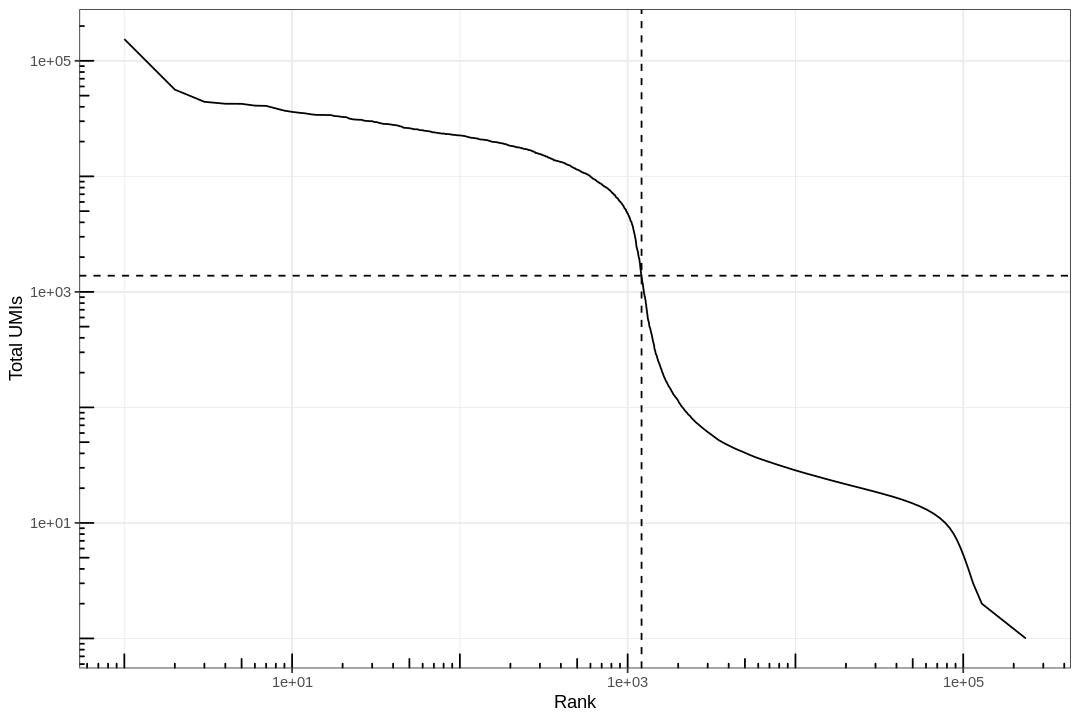

In [22]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

In [23]:
# Filter the matrix
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 20198  1210

In [0]:
rownames(res_mat) <- str_remove(rownames(res_mat), "\\.\\d+")

In [174]:
mouse.rnaseq <- MouseRNAseqData(ensembl = TRUE)
sce <- SingleCellExperiment(assays = list(counts = res_mat))
sce <- logNormCounts(sce)

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

snapshotDate(): 2019-10-22

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

loading from cache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

loading from cache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

Using temporary cache /tmp/Rtmp3ZgCkF/BiocFileCache

snapshotDat

In [0]:
annots <- SingleR(sce, ref = mouse.rnaseq, labels = colData(mouse.rnaseq)$label.fine,
de.method = "wilcox", method = "single", BPPARAM = MulticoreParam(2))

In [38]:
annots

DataFrame with 1210 rows and 5 columns
                                                                        scores
                                                                      <matrix>
AAACGCTGTAATGTGA    0.0601901483760862:0.242986808015721:0.177660752587073:...
AAACGCTGTCCTGGGT      0.11153546550616:0.321858508786419:0.206383027494298:...
AAAGAACCAGGACATG    0.0585569289411892:0.225038532259566:0.177381655702582:...
AAAGGTACACACGGTC       0.137923692580242:0.3506611435018:0.281933499704427:...
AAAGGTATCACCATAG -0.00511350381259525:0.166880227412372:0.0975899954539976:...
...                                                                        ...
TTTGACTTCGTTCAGA     0.100933655338997:0.327948884202836:0.262011719832591:...
TTTGATCTCCATAGGT     0.0656536744266451:0.280702755051776:0.23375860874247:...
TTTGGAGAGGCTAACG    0.0681422805975054:0.234772340818692:0.176292333613646:...
TTTGGTTAGTAATCCC     0.125780004617712:0.315213344287222:0.258722018820061:...
TTTGTTGGTATGG

In [0]:
inds <- annots$pruned.labels %in% c("NPCs", "Neurons", "OPCs", "Oligodendrocytes", 
                                    "qNSCs", "aNSCs", "Astrocytes", "Ependymal")
# Only keep these cell types
cells_use <- row.names(annots)[inds]
sce <- sce[, cells_use]
sce$cell_type <- annots$pruned.labels[inds]

# QC

In [176]:
df <- perCellQCMetrics(sce)
colData(sce) <- cbind(colData(sce), df)
colData(sce)

DataFrame with 1146 rows and 8 columns
                   cell_type       sum  detected   percent_top_50
                 <character> <numeric> <integer>        <numeric>
AAACGCTGTAATGTGA       aNSCs      7072      3256 19.0328054298643
AAACGCTGTCCTGGGT       aNSCs      9458      4101 12.8991330090928
AAAGAACCAGGACATG       aNSCs      5338      2577 20.7006369426752
AAAGGTACACACGGTC       aNSCs     16892      5111 18.2098034572579
AAAGGTATCACCATAG       aNSCs      1397       882 24.9105225483178
...                      ...       ...       ...              ...
TTTGACTTCGTTCAGA       aNSCs     26203      6091 21.4021295271534
TTTGATCTCCATAGGT       aNSCs      8120      3625 16.7980295566502
TTTGGAGAGGCTAACG     Neurons      5483      2737 21.8675907349991
TTTGGTTAGTAATCCC     Neurons     24381      5927 20.2288667404946
TTTGTTGGTATGGAAT     Neurons      3718      2324 14.6046261430877
                  percent_top_100  percent_top_200  percent_top_500     total
                        <

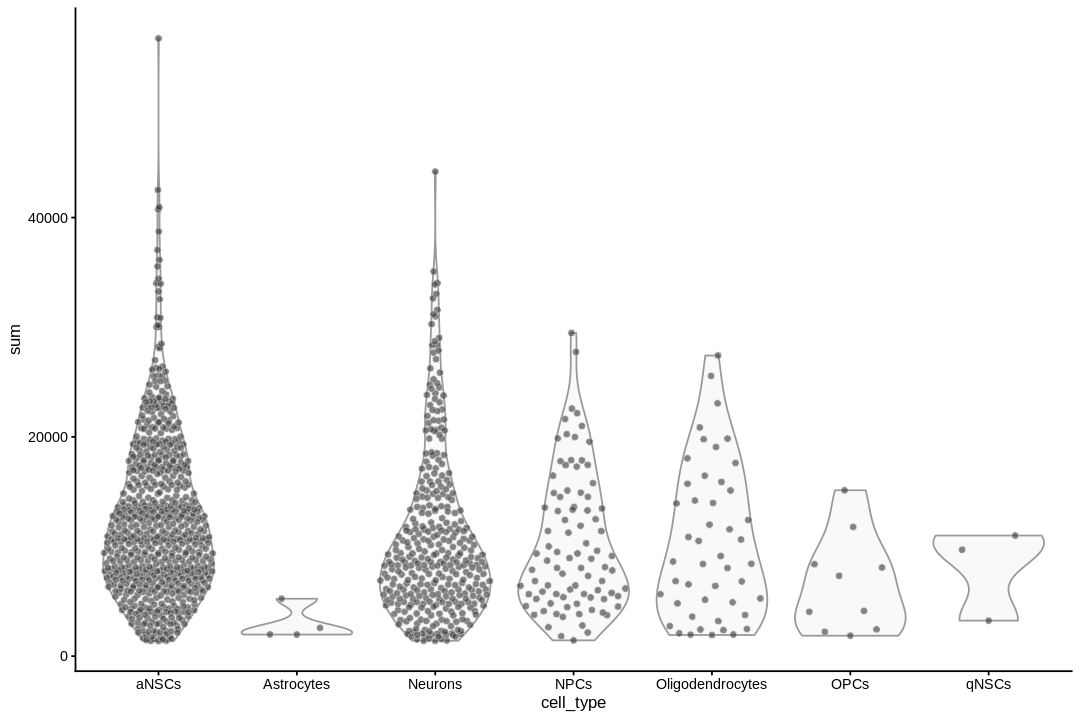

In [177]:
plotColData(sce, x = "cell_type", y = "sum")

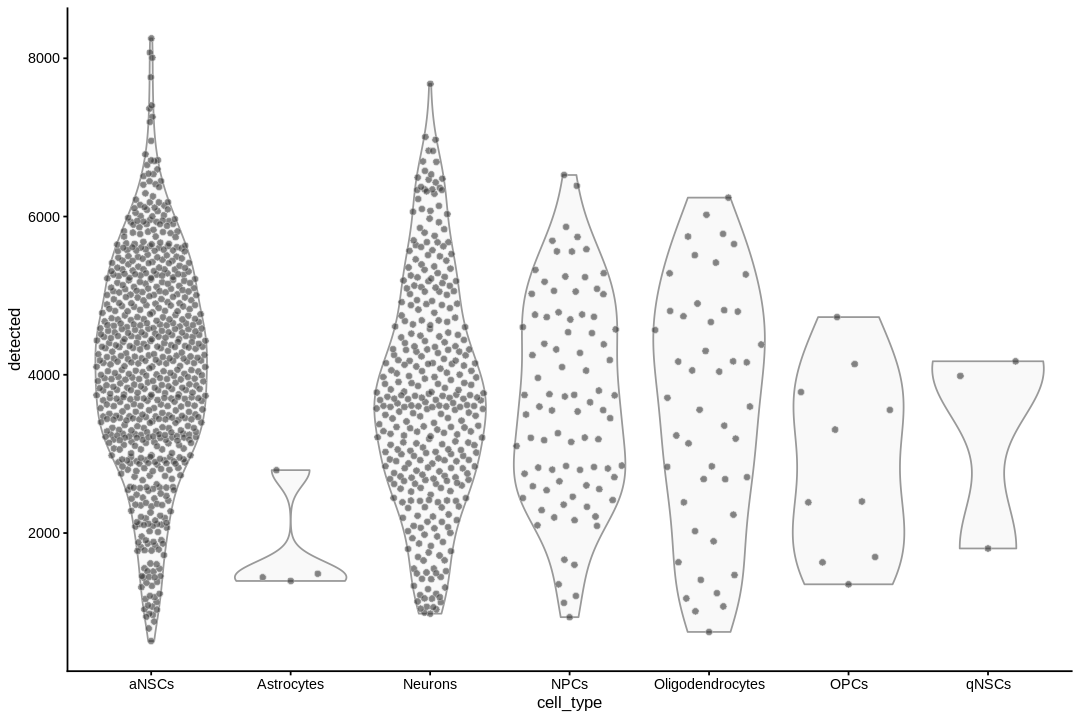

In [178]:
plotColData(sce, x = "cell_type", y = "detected")

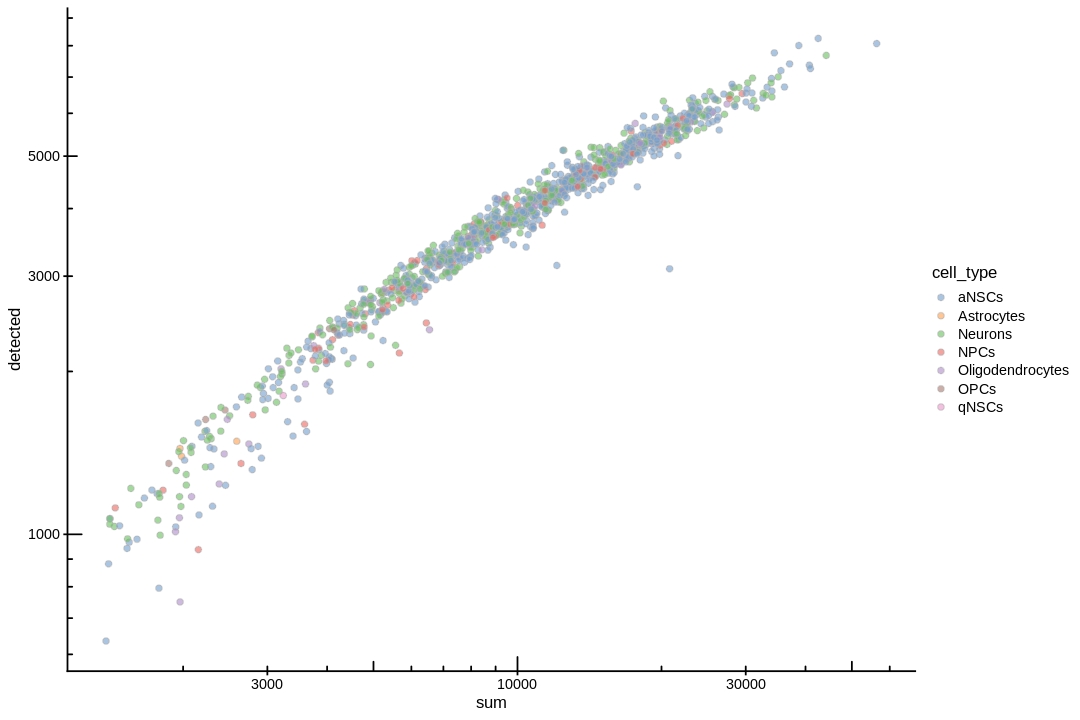

In [179]:
plotColData(sce, x = "sum", y = "detected", colour_by = "cell_type") +
  scale_x_log10() +
  scale_y_log10() +
  annotation_logticks()

## Dimension reduction

In [0]:
dec_sce <- modelGeneVar(sce)
fit_pbmc <- metadata(dec_sce)

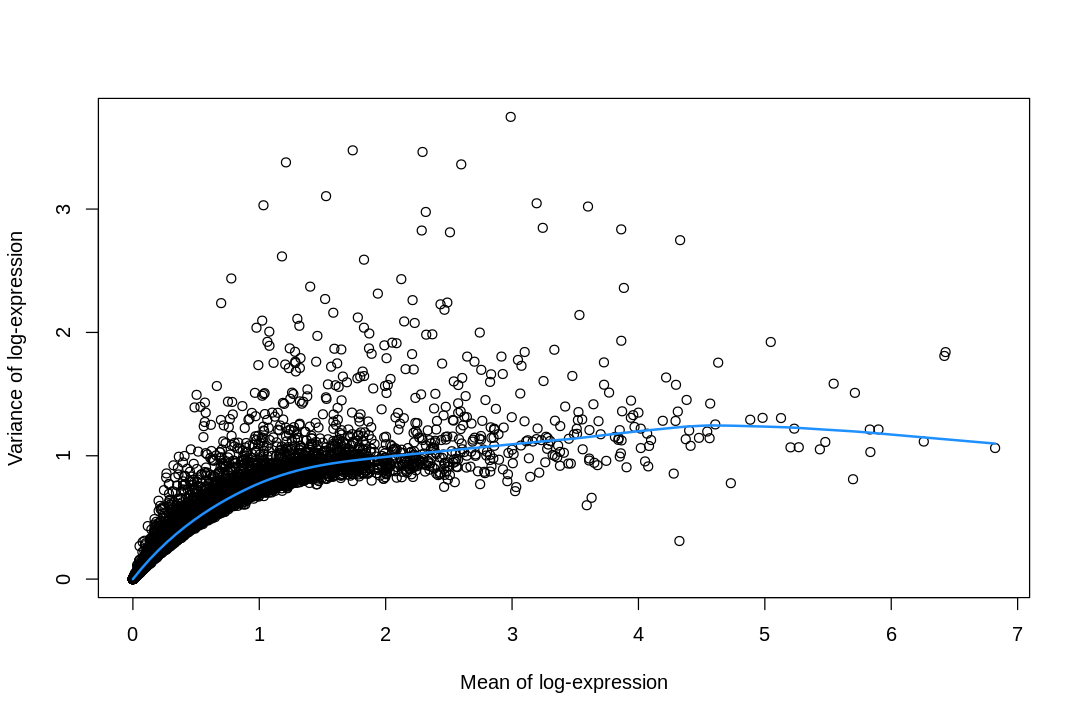

In [181]:
# Adapted from https://osca.bioconductor.org/feature-selection.html#feature-selection
plot(fit_pbmc$mean, fit_pbmc$var, xlab="Mean of log-expression",
    ylab="Variance of log-expression")
curve(fit_pbmc$trend(x), col="dodgerblue", add=TRUE, lwd=2)

In [0]:
hvgs <- getTopHVGs(dec_sce, n = 3000)
sce <- runPCA(sce, subset_row = hvgs)

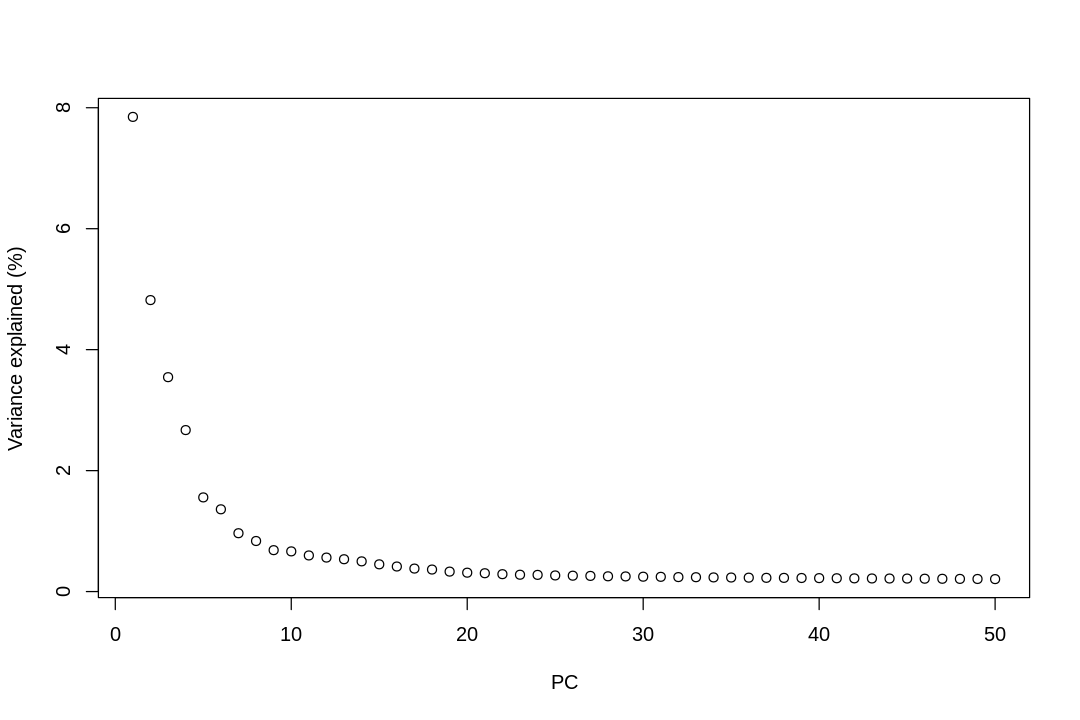

In [183]:
# Percentage of variance explained is tucked away in the attributes.
percent.var <- attr(reducedDim(sce), "percentVar")
plot(percent.var, xlab="PC", ylab="Variance explained (%)")

The y axis is percentage of variance explained by the PC, or the eigenvalues of the covariance matrix.

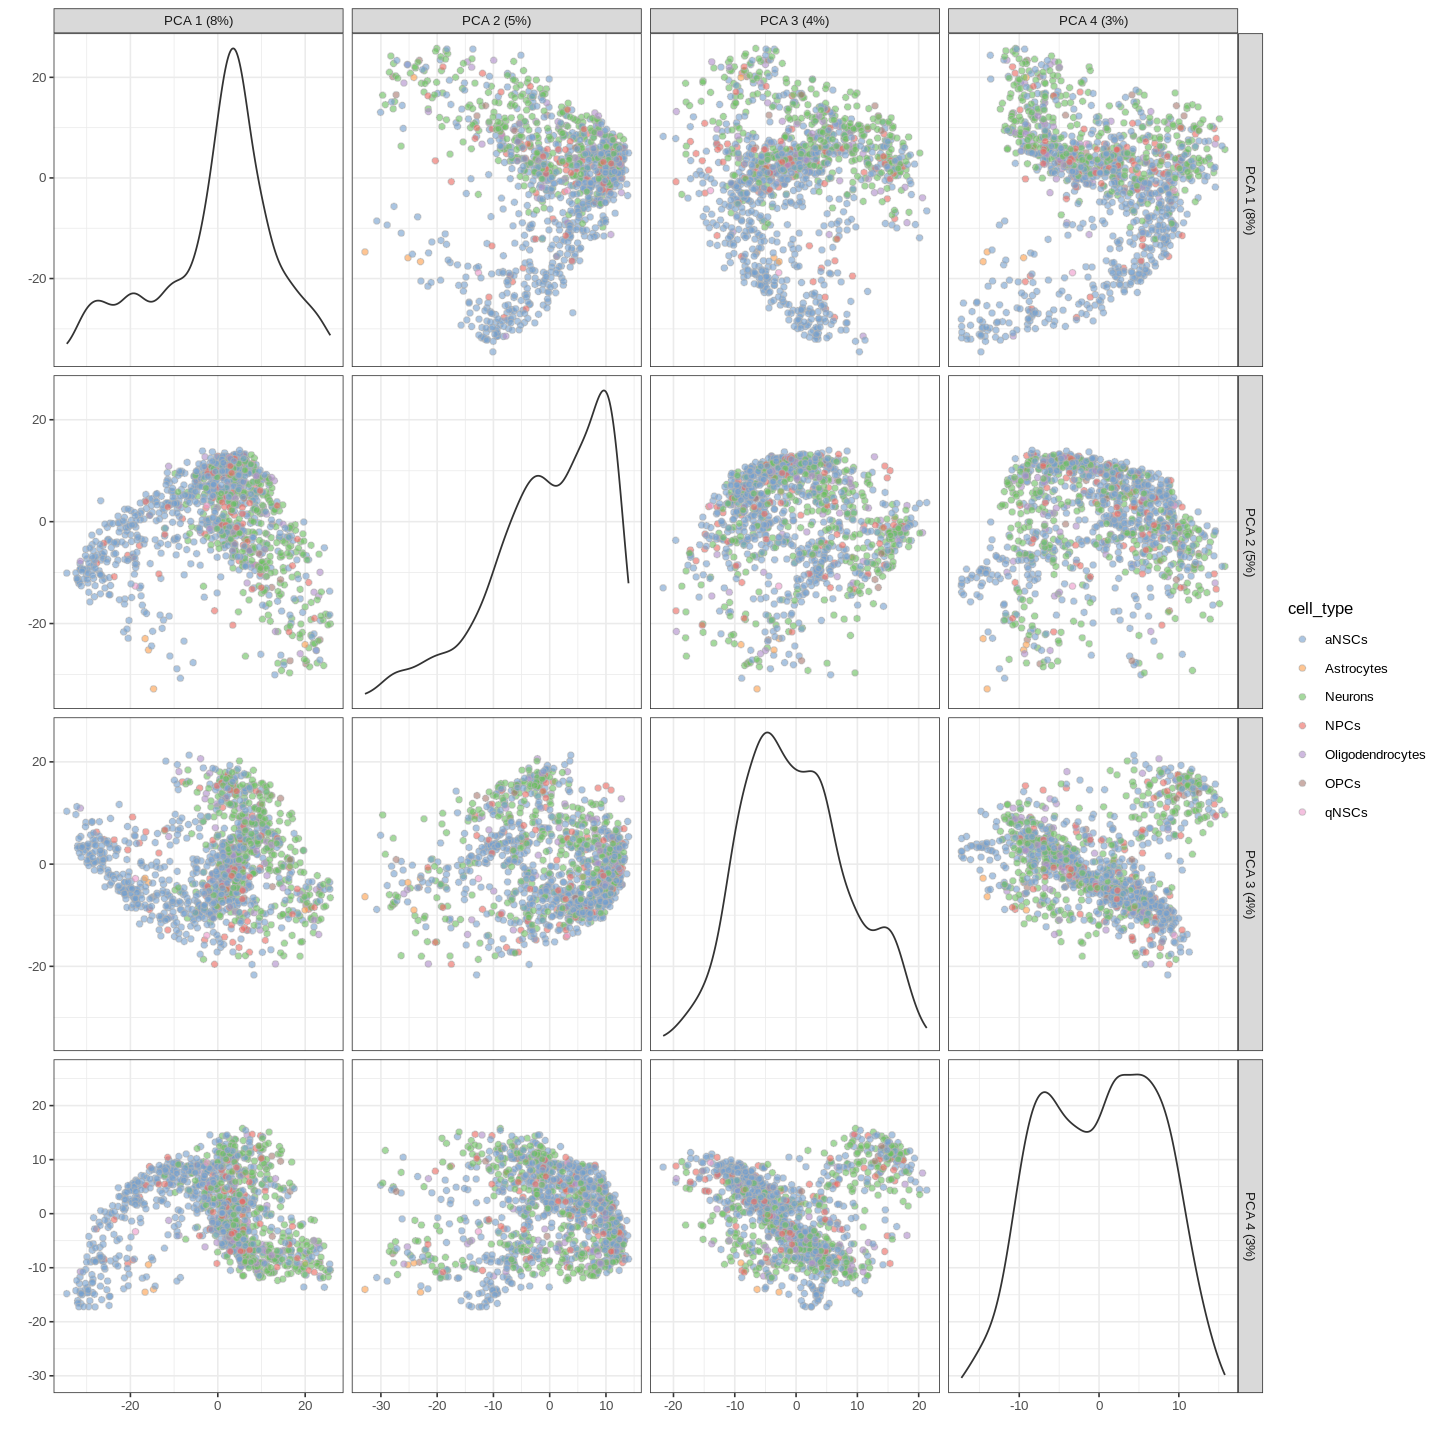

In [184]:
options(repr.plot.width=12, repr.plot.height=12)
plotPCA(sce, colour_by = "cell_type", ncomponents = 4)

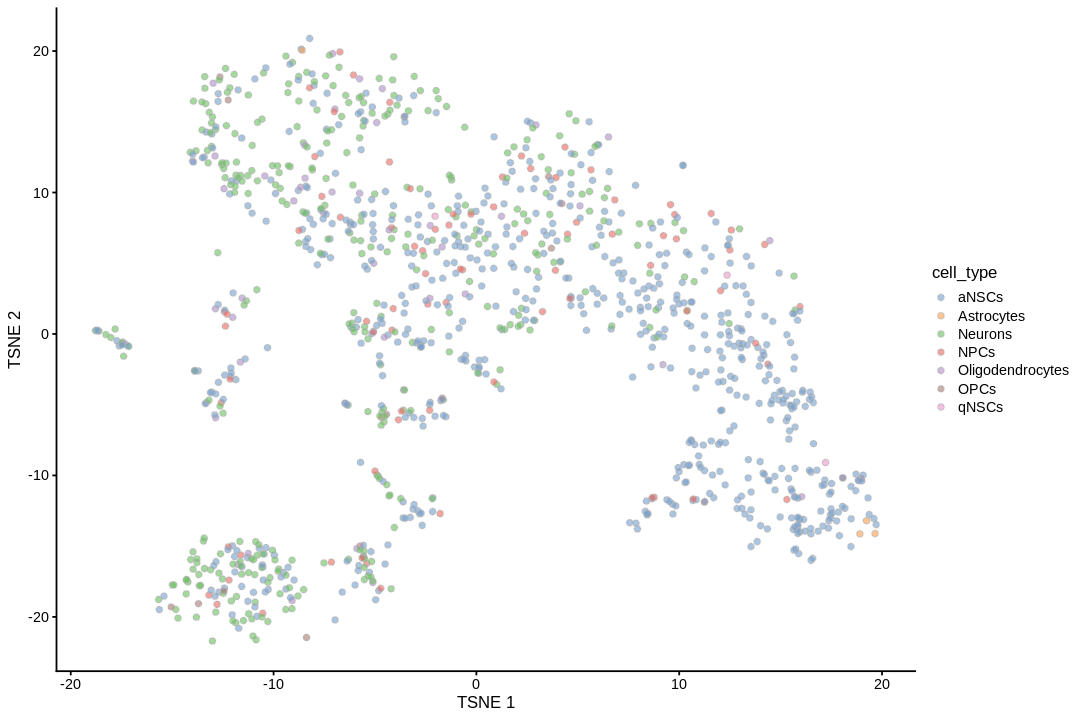

In [185]:
options(repr.plot.width=9, repr.plot.height=6)
sce <- runTSNE(sce, dimred = "PCA")
plotTSNE(sce, colour_by = "cell_type")

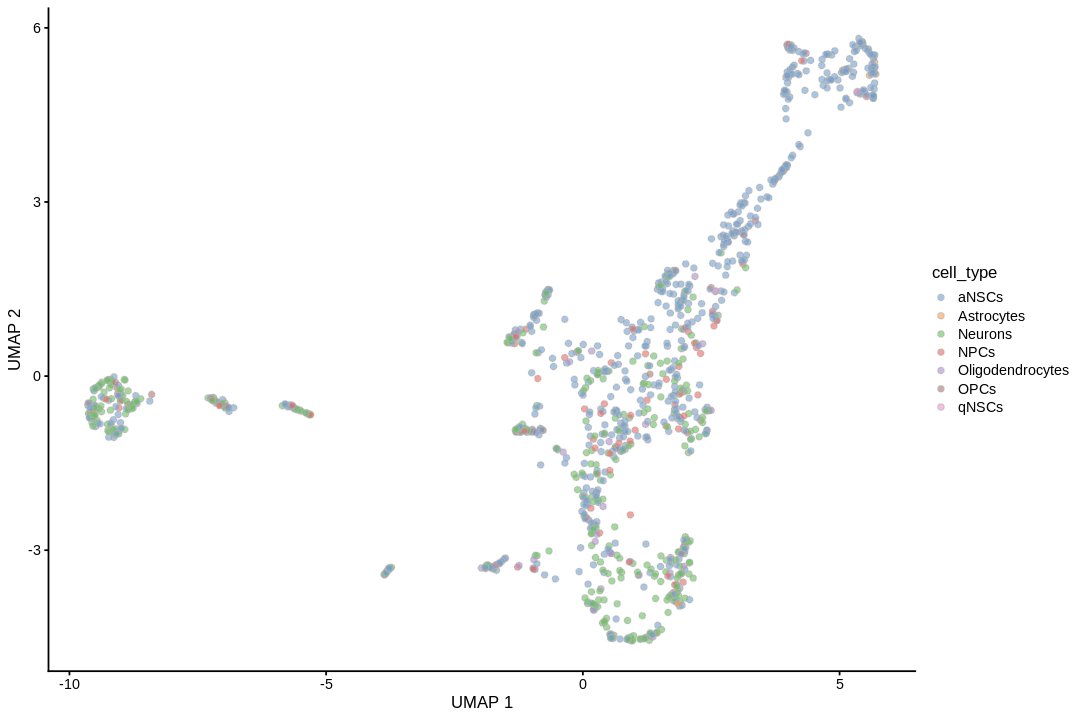

In [186]:
set.seed(1)
sce <- runUMAP(sce, dimred = "PCA", n_neighbors = 30)
plotUMAP(sce, colour_by = "cell_type")

UMAP can better preserve pairwise distance of cells than tSNE and can better separate cell populations than the first 2 PCs of PCA ([Becht et al. 2018](https://doi.org/10.1038/nbt.4314)), so the TI will be visualized on UMAP rather than tSNE or PCA. 

Cell type annotation with `SingleR` requires a reference with bulk RNA seq data for isolated known cell types. The reference used for cell type annotation here does not differentiate between different types of neural progenitor cells; clustering can further partition the neural progenitor cells. Furthermore, `slingshot` is based on cluster-wise minimum spanning tree, so finding a good clustering is important to good trajectory inference with `slingshot`. The clustering algorithm used here is [Leiden](https://www.nature.com/articles/s41598-019-41695-z), which is an improvement over the commonly used Louvain; Leiden communities are guaranteed to be well-connected, while Louvain can lead to poorly connected communities.

In [0]:
g <- buildSNNGraph(sce, k = 15, use.dimred = "PCA")

In [0]:
sce$cluster <- leidenbase::leiden_find_partition(g, resolution_parameter = 1.2, 
  partition_type = "RBConfigurationVertexPartition",
  num_iter = 10, seed = 1)$membership %>% factor()

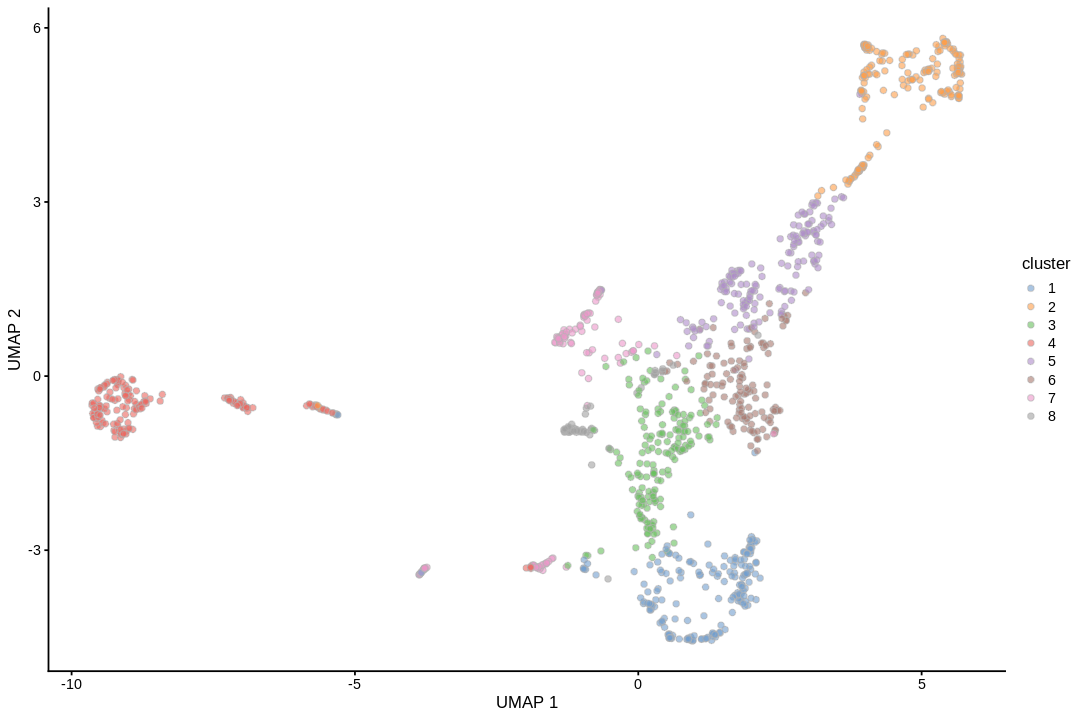

In [188]:
plotUMAP(sce, colour_by = "cluster")

# Slingshot
## Trajectory inference
While the `slingshot` vignette uses `SingleCellExperiment`, `slingshot` can also take a matrix of cell embeddings in reduced dimension as input. We can optionally specify the cluster to start or end the trajectory based on biological knowledge. Here, since quiescent neural stem cells are in cluster 4, the starting cluster would be 4 near the top left of the previous plot.

**I no longer consider doing trajectory inference on UMAP a good idea**, due to distortions introduced by UMAP. See [this paper](https://www.biorxiv.org/content/10.1101/689851v3) for the extent non-linear dimension reduction methods distort the data. The latent dimension of the data is most likely far more than 2 or 3 dimensions, so forcing it down to 2 or 3 dimensions are bound to introduce distortions, just like how projecting the spherical surface of the Earth to 2 dimensions in maps introduces distortions. Furthermore, after the projection, some trajectories are no longer topologically feasible. For instance, imagine a stream coming out of the hole of a doughnut in 3D. This is not possible in 2D, so when that structure is projected to 2D, part of the stream may become buried in the middle of the doughnut, or the doughnut may be broken to allow the stream through, or part of the steam will be intermixed with part of the doughnut though they shouldn't. I recommend using a larger number of principal components instead, but in that case, the lineages and principal curves can't be visualized (we can plot the curves within a 2 dimensional subspace, such as the first 2 PCs, but that usually looks like abstract art and isn't informative about the lineages).

In [123]:
sds <- slingshot(reducedDim(sce, "PCA")[,1:20], clusterLabels = sce$cluster, 
                 start.clus = 2, stretch = 0)

Using full covariance matrix



Unfortunately, `slingshot` does not natively support `ggplot2`. So this is a function that assigns colors to each cell in base R graphics.

In [0]:
#' Assign a color to each cell based on some value
#' 
#' @param cell_vars Vector indicating the value of a variable associated with cells.
#' @param pal_fun Palette function that returns a vector of hex colors, whose
#' argument is the length of such a vector.
#' @param ... Extra arguments for pal_fun.
#' @return A vector of hex colors with one entry for each cell.
cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

We need color palettes for both cell types and Leiden clusters. These would be the same colors seen in the Seurat plots.

In [0]:
cell_colors <- cell_pal(sce$cell_type, pal_d3(alpha = 0.5))
cell_colors_clust <- cell_pal(sce$cluster, pal_d3(alpha = 0.5))

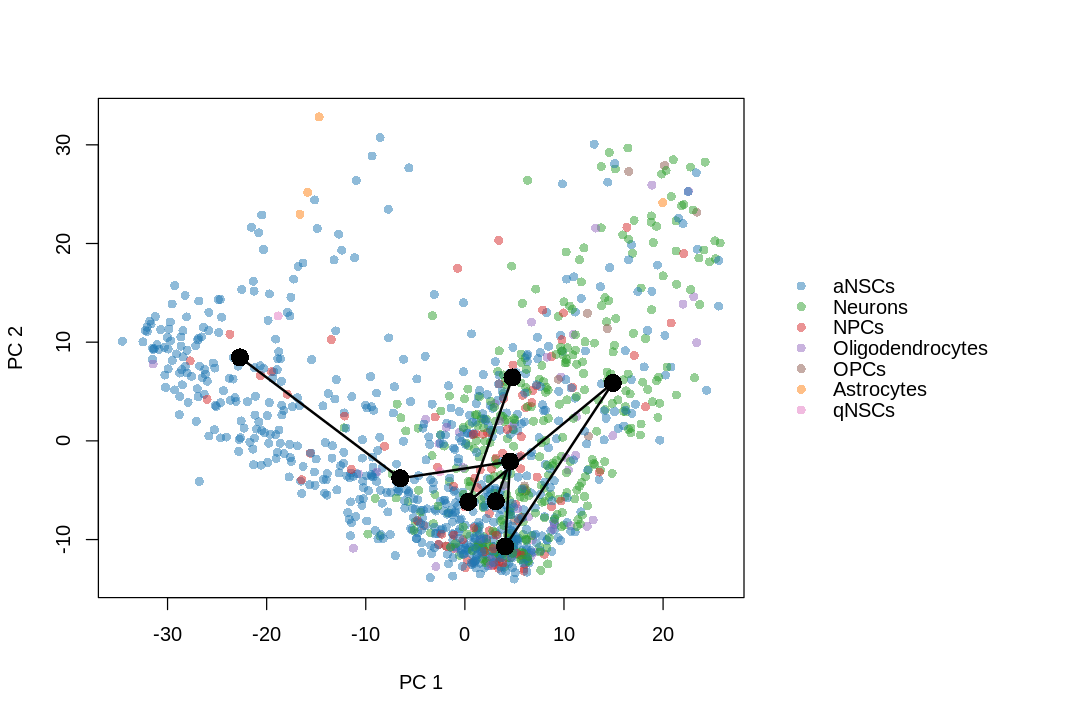

In [147]:
par(mar=c(5.1, 4.1, 4.1, 14), xpd=TRUE)
plot(reducedDim(sds, "PCA")[,1:2], col = cell_colors, pch = 16, cex = 1, xlab = "PC 1", ylab = "PC 2")
lines(sds, lwd = 2, type = 'lineages', col = 'black')
legend("right", inset = c(-0.6, 0), legend = unique(sce$cell_type), 
       col = unique(cell_colors), pch = 16, box.lwd = 0)

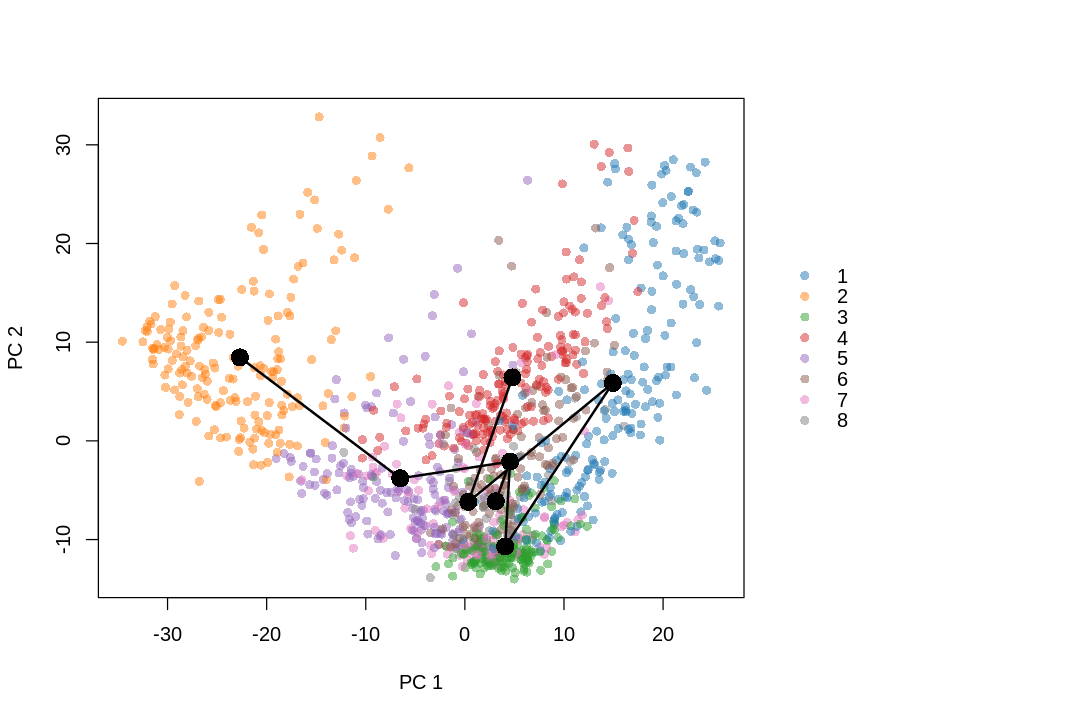

In [148]:
ord <- order(unique(sce$cluster))
par(mar=c(5.1, 4.1, 4.1, 14), xpd=TRUE)
plot(reducedDim(sds, "PCA")[,1:2], col = cell_colors_clust, pch = 16, cex = 1, xlab = "PC 1", ylab = "PC 2")
lines(sds, lwd = 2, type = 'lineages', col = 'black')
legend("right", inset = c(-0.2, 0), legend = unique(sce$cluster)[ord], 
       col = unique(cell_colors_clust)[ord], pch = 16, box.lwd = 0)

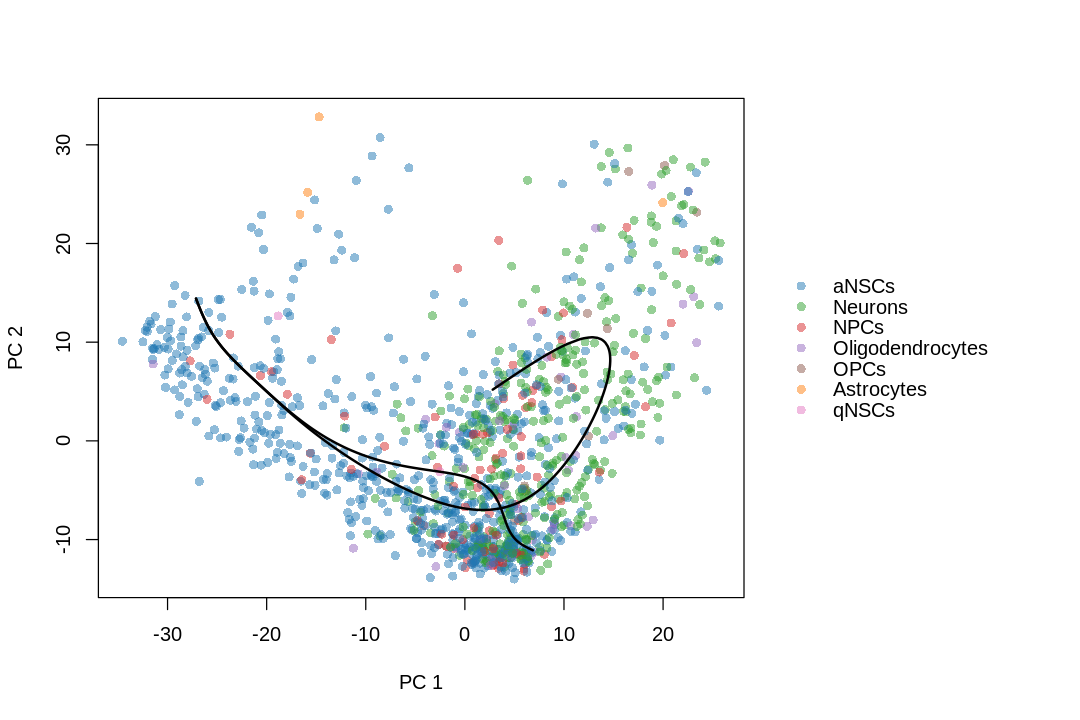

In [149]:
par(mar=c(5.1, 4.1, 4.1, 14), xpd=TRUE)
plot(reducedDim(sds, "PCA")[,1:2], col = cell_colors, pch = 16, cex = 1, xlab = "PC 1", ylab = "PC 2")
lines(sds, lwd = 2, col = 'black')
legend("right", inset = c(-0.6, 0), legend = unique(sce$cell_type), 
       col = unique(cell_colors), pch = 16, box.lwd = 0)

Which cells are in which lineage? Here we plot the pseudotime values for each lineage.

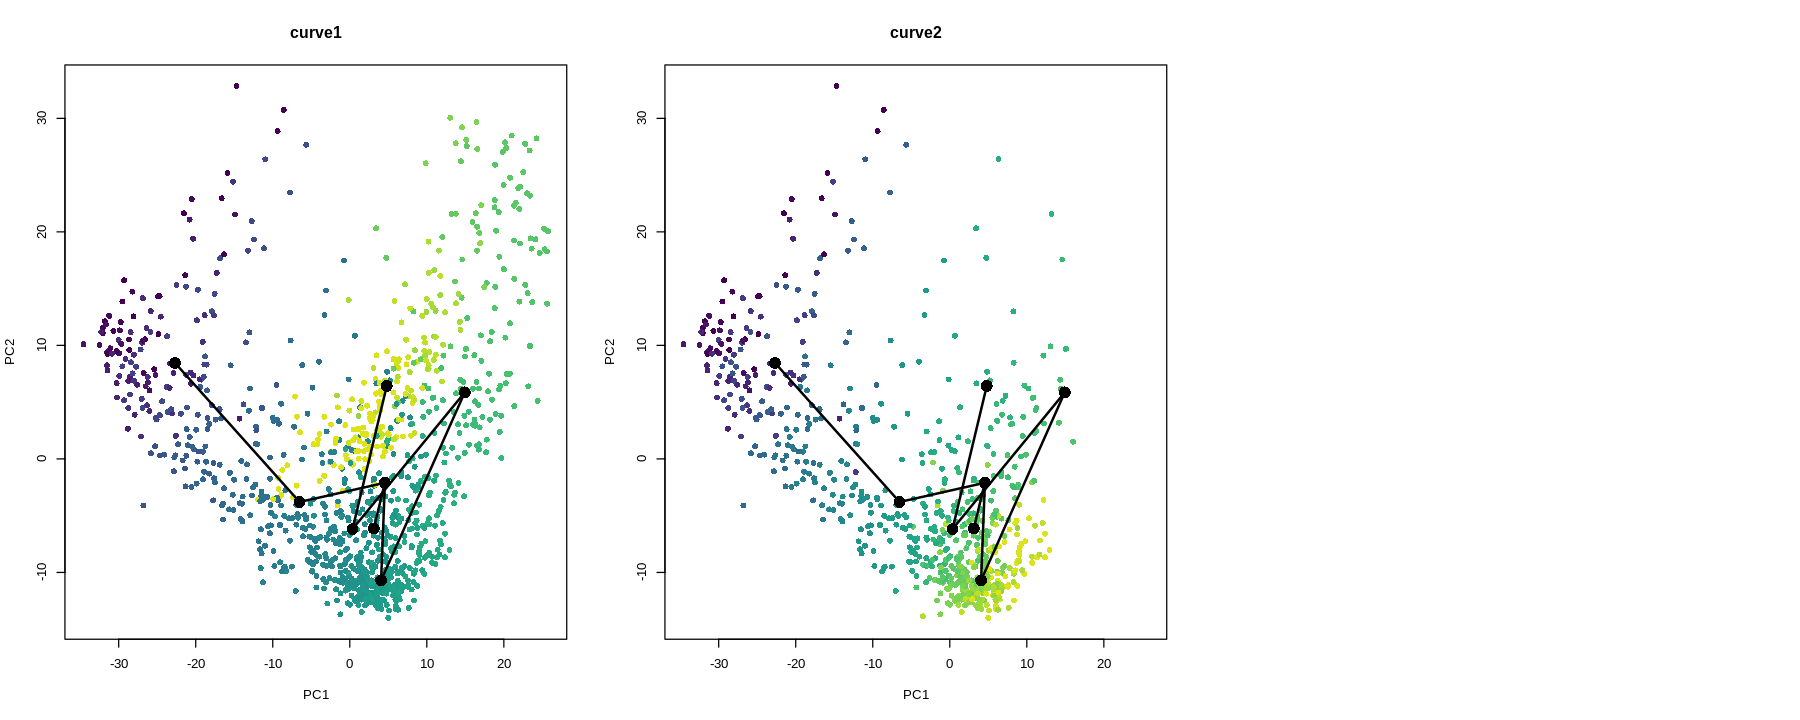

In [152]:
options(repr.plot.width=15, repr.plot.height=6)
nc <- 3
pt <- slingPseudotime(sds)
nms <- colnames(pt)
nr <- ceiling(length(nms)/nc)
pal <- viridis(100, end = 0.95)
par(mfrow = c(nr, nc))
for (i in nms) {
  colors <- pal[cut(pt[,i], breaks = 100)]
  plot(reducedDim(sds), col = colors, pch = 16, main = i)
  lines(sds, lwd = 2, col = 'black', type = 'lineages')
}

Or on UMAP, though can't plot the lineages here

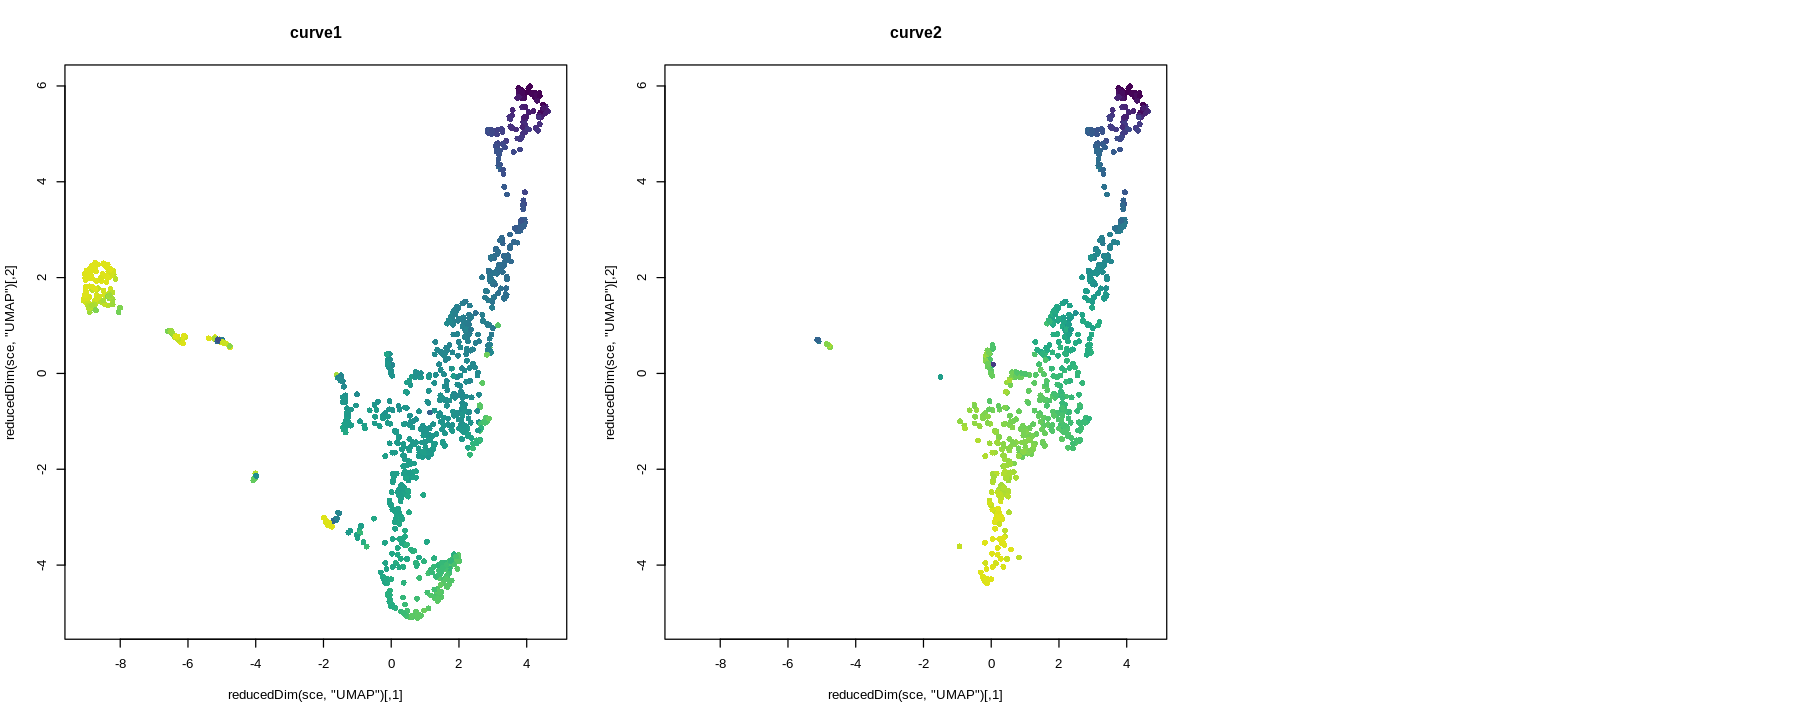

In [154]:
par(mfrow = c(nr, nc))
options(repr.plot.width=15, repr.plot.height=6)
for (i in nms) {
  colors <- pal[cut(pt[,i], breaks = 100)]
  plot(reducedDim(sce, "UMAP"), col = colors, pch = 16, main = i)
}

# Differential expression
Here we use the package `tradeSeq`, presented in [this paper](https://www.biorxiv.org/content/10.1101/623397v1). This section was adapted from the vignette of `tradeSeq`.

Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Fitting terminated with step failure - check results carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Iteration limit reached without full convergence - check carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Fitting terminated with step failure - check results carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Fitting terminated with step failure - check results carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Iteration limit reached without full convergence - check carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
"Fitting terminated with step failure - check results carefully"
Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$

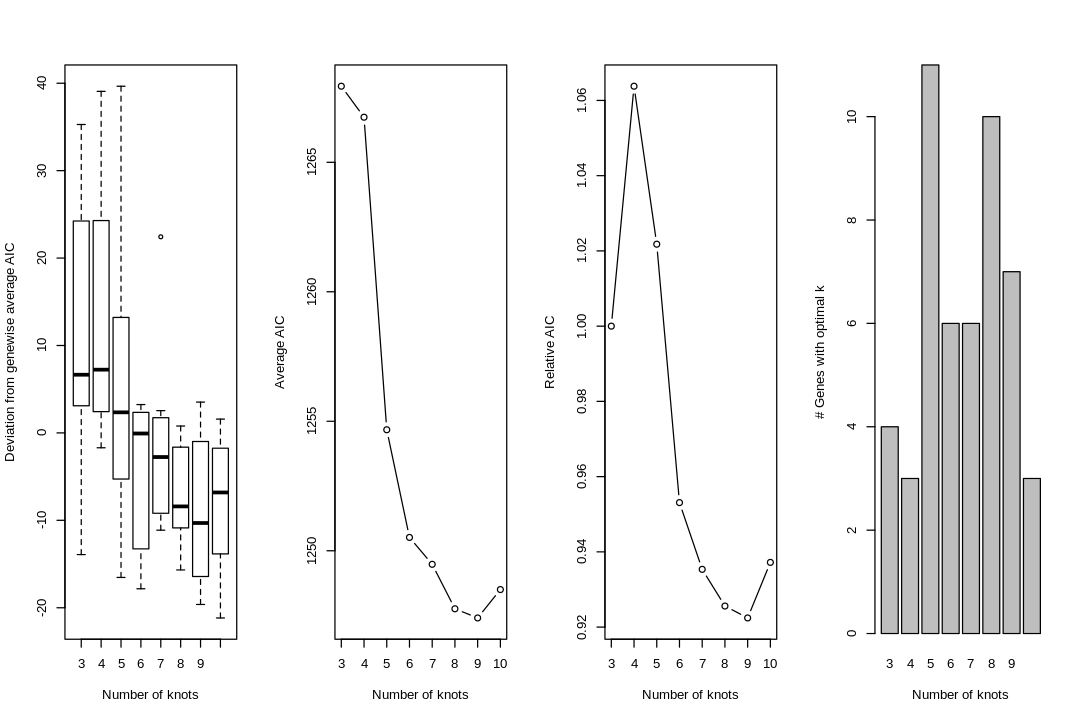

In [165]:
control <- mgcv::gam.control()
control$maxit <- 1000
cts <- as.matrix(counts(sce))
icMat <- evaluateK(counts = cts, k=3:10, nGenes = 50,
                   pseudotime = slingPseudotime(sds, na = FALSE),
                   cellWeights = slingCurveWeights(sds), control = control)

In [0]:
register(MulticoreParam(2))
sce2 <- fitGAM(counts = cts[hvgs[1:50],], sds = sds, nknots = 5, control = control)

See where the knots are

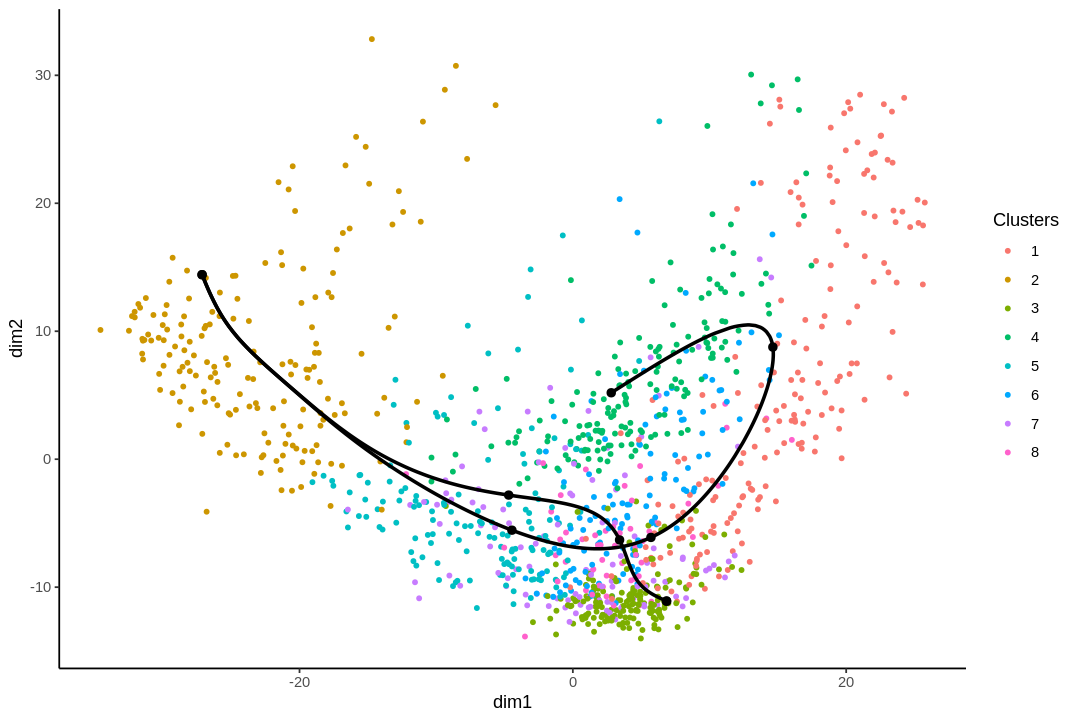

In [191]:
plotGeneCount(curve = sds, clusters = sce$cluster,
              models = sce2)

## Within linenage comparisons

In [192]:
assoRes <- associationTest(sce2)
head(assoRes)

,waldStat,df,pvalue
,<dbl>,<dbl>,<dbl>
ENSMUSG00000027500,749.6209,7,0
ENSMUSG00000019874,1765.8955,7,0
ENSMUSG00000005583,579.4966,7,0
ENSMUSG00000029838,504.3415,7,0
ENSMUSG00000027210,492.3774,7,0
ENSMUSG00000026728,1072.9275,7,0


In [0]:
startRes <- startVsEndTest(sce2)

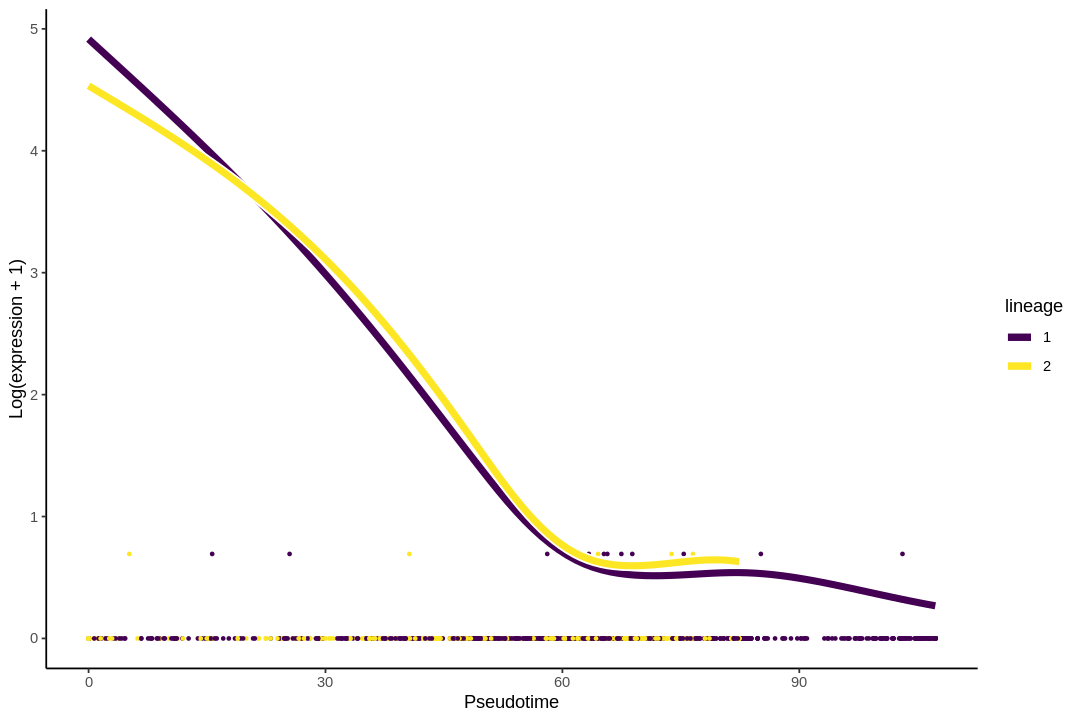

In [196]:
oStart <- order(startRes$waldStat, decreasing = TRUE)
sigGeneStart <- names(sce2)[oStart[1]]
plotSmoothers(sce2, cts, gene = sigGeneStart)

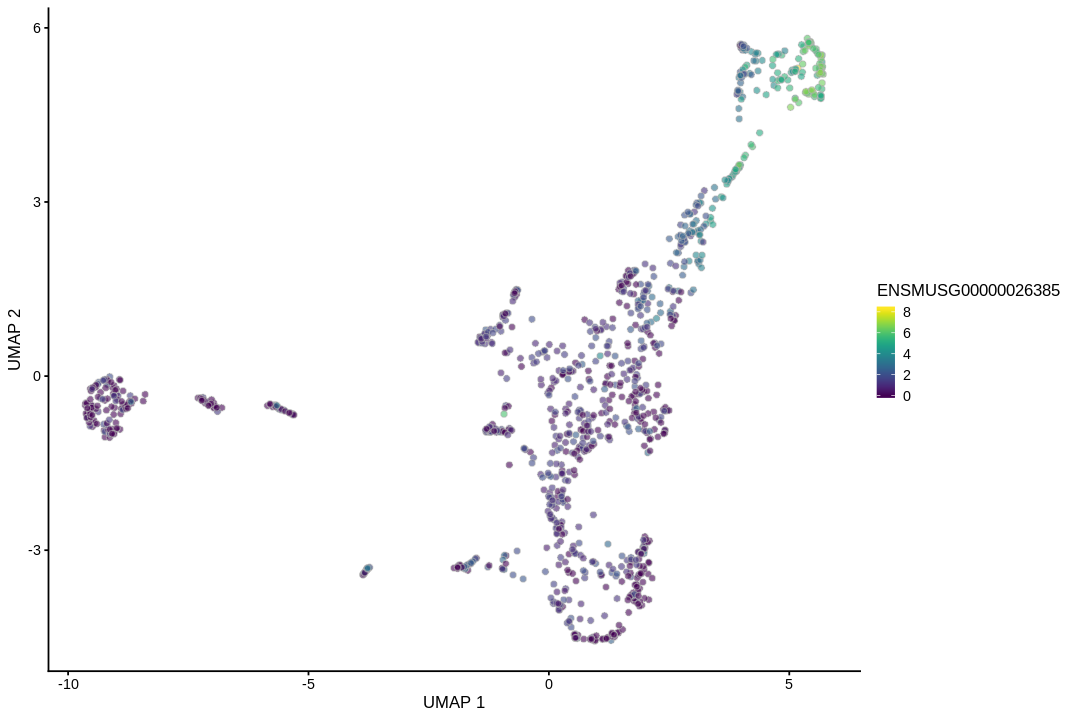

In [197]:
plotUMAP(sce, colour_by = sigGeneStart)

## Between lineage comparisons

In [0]:
endRes <- diffEndTest(sce2)

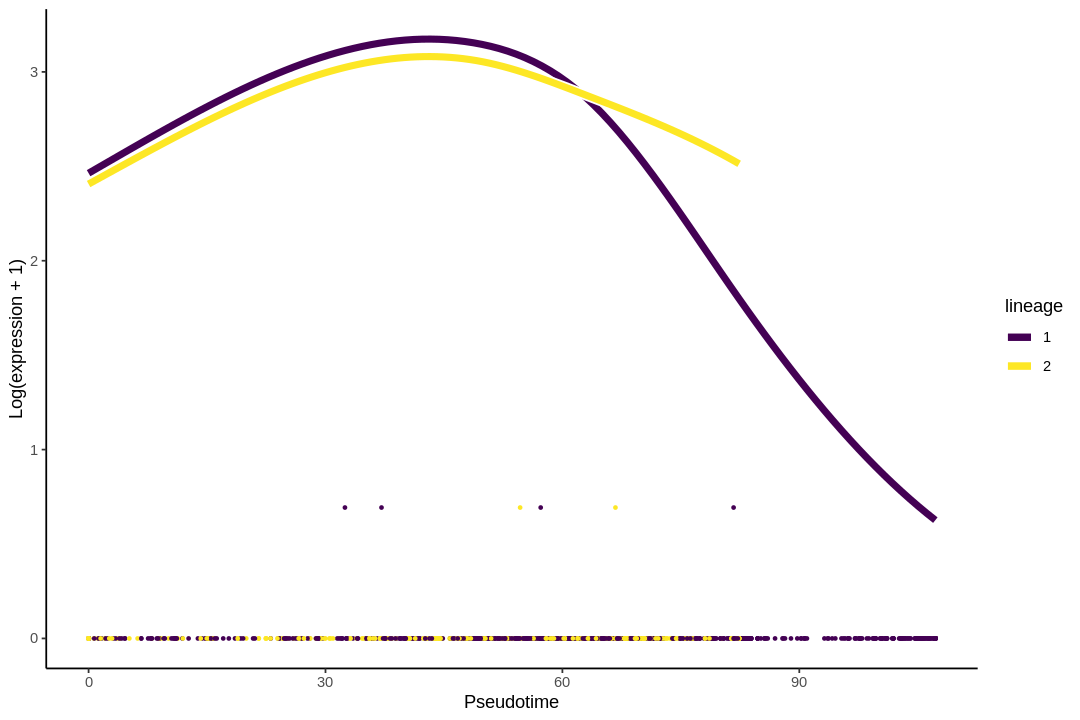

In [202]:
o <- order(endRes$waldStat, decreasing = TRUE)
sigGene <- names(sce2)[o[1]]
plotSmoothers(sce2, cts, sigGene)

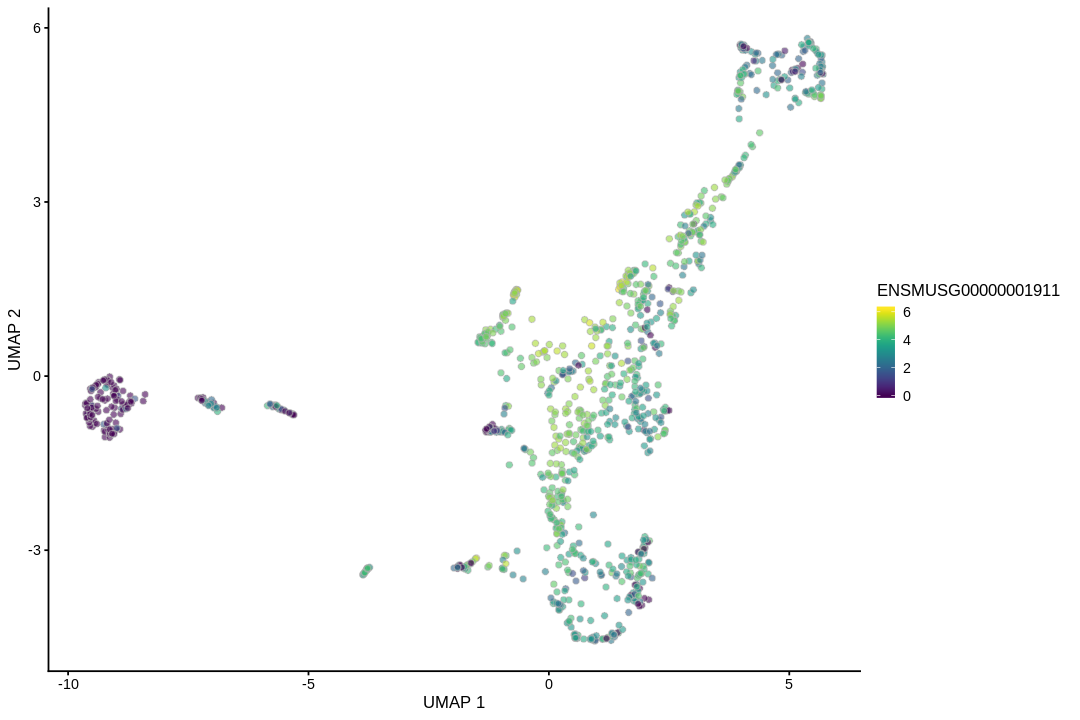

In [204]:
plotUMAP(sce, colour_by = sigGene)

## Different patterns

In [205]:
patternRes <- patternTest(sce2)
oPat <- order(patternRes$waldStat, decreasing = TRUE)
head(rownames(patternRes)[oPat])

[1] "ENSMUSG00000035551" "ENSMUSG00000027239" "ENSMUSG00000018411"
[4] "ENSMUSG00000067786" "ENSMUSG00000052727" "ENSMUSG00000058672"

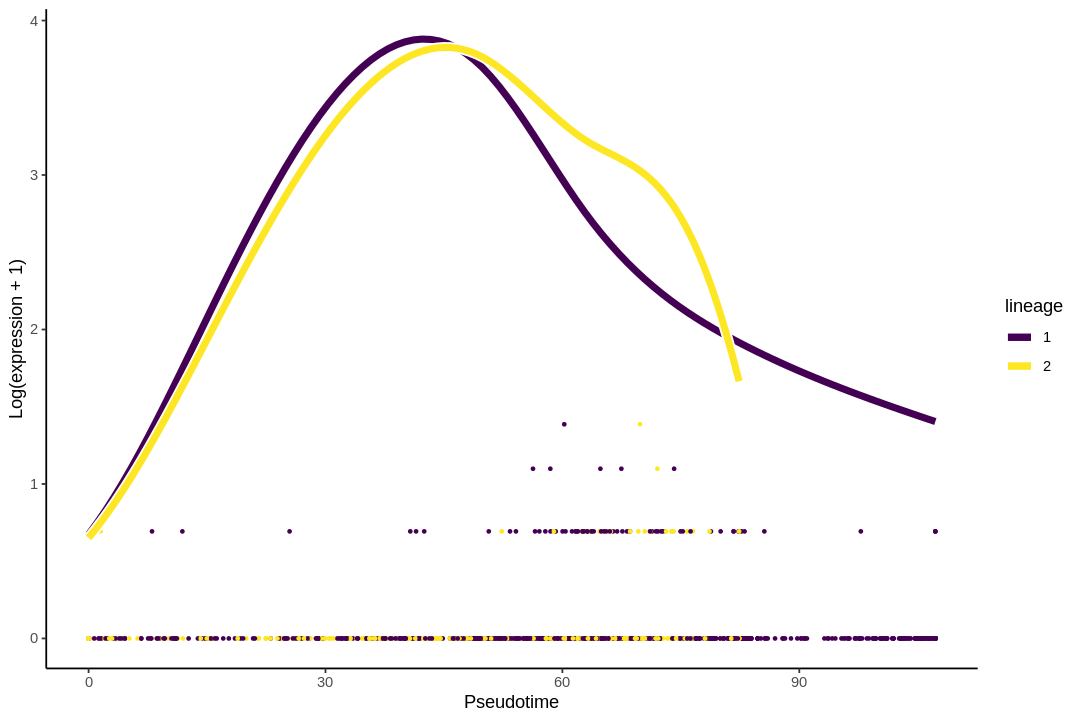

In [206]:
plotSmoothers(sce2, cts, gene = rownames(patternRes)[oPat][1])

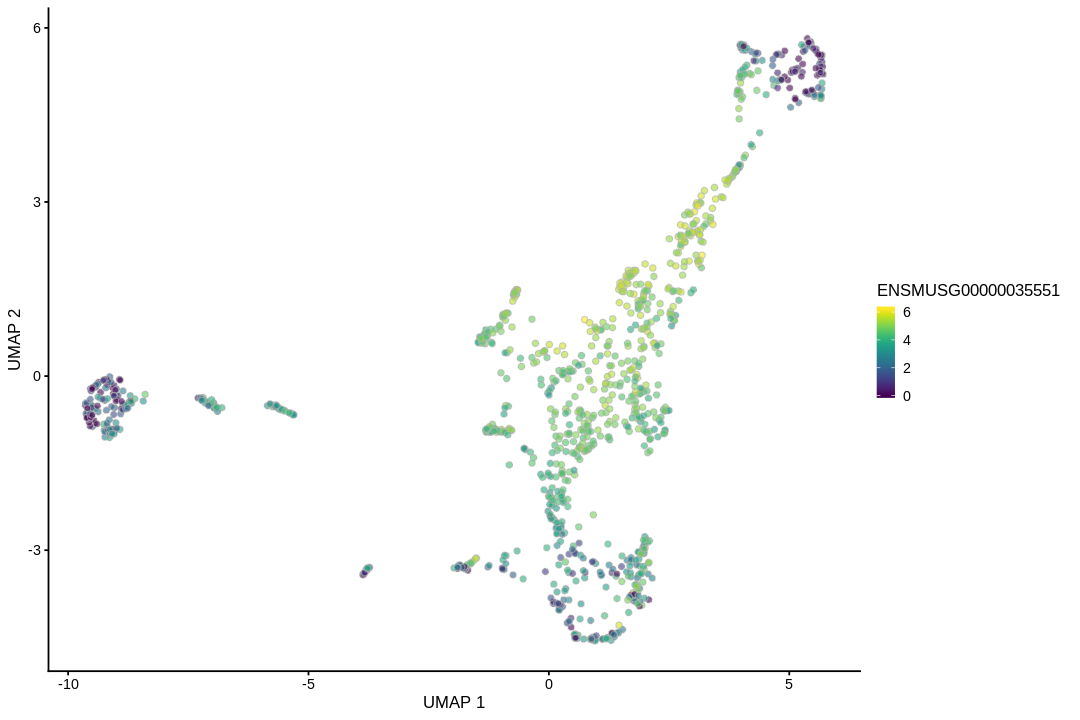

In [207]:
plotUMAP(sce, colour_by = rownames(patternRes)[oPat][1])

## Clustering patterns

In [0]:
nPointsClus <- 10
clusPat <- clusterExpressionPatterns(sce2, nPoints = nPointsClus,
                                     genes = rownames(sce2))

In [0]:
clusterLabels <- primaryCluster(clusPat$rsec)

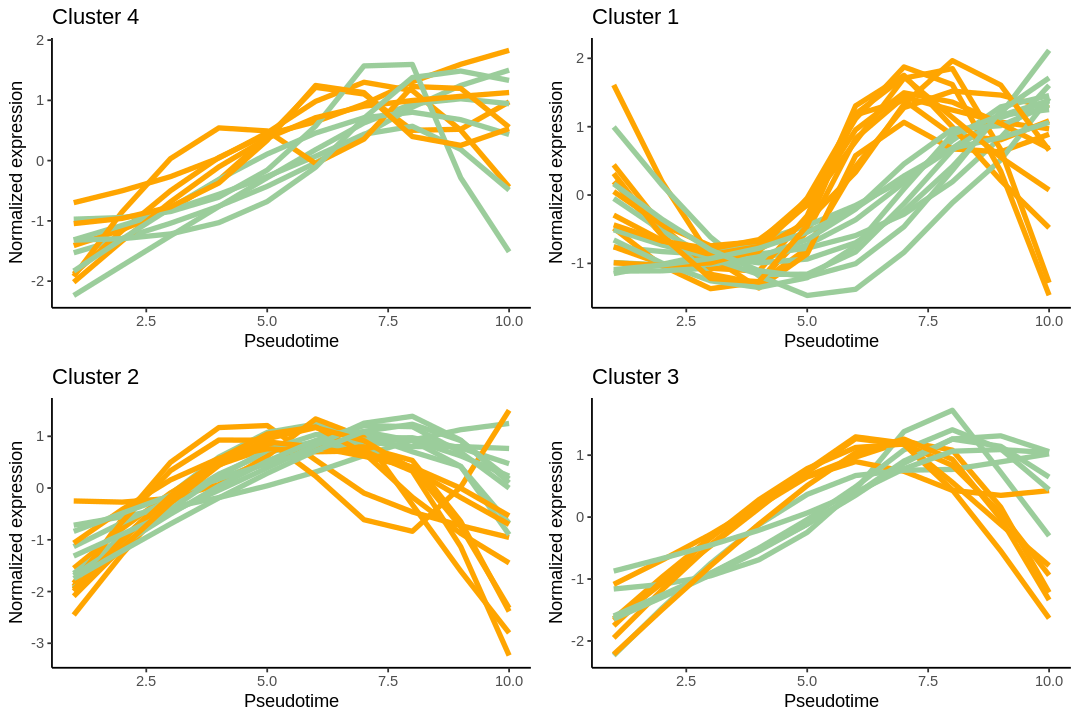

In [216]:
cUniq <- unique(clusterLabels)
cUniq <- cUniq[!cUniq == -1] # remove unclustered genes

plots <- list()
for (xx in cUniq[1:4]) {
  cId <- which(clusterLabels == xx)
  p <- ggplot(data = data.frame(x = 1:nPointsClus,
                                y = rep(range(clusPat$yhatScaled[cId, ]),
                                        nPointsClus / 2)),
              aes(x = x, y = y)) +
    geom_point(alpha = 0) +
    labs(title = paste0("Cluster ", xx),  x = "Pseudotime", y = "Normalized expression") +
    theme_classic()
  for (ii in 1:length(cId)) {
    geneId <- rownames(clusPat$yhatScaled)[cId[ii]]
    p <- p +
      geom_line(data = data.frame(x = rep(1:nPointsClus, 2),
                                  y = clusPat$yhatScaled[geneId, ],
                                  lineage = rep(0:1, each = nPointsClus)),
                aes(col = as.character(lineage), group = lineage), lwd = 1.5)
  }
  p <- p + guides(color = FALSE) +
    scale_color_manual(values = c("orange", "darkseagreen3"),
                       breaks = c("0", "1"))  
  plots[[as.character(xx)]] <- p
}
plots$ncol <- 2
do.call(cowplot::plot_grid, plots)
